<a href="https://colab.research.google.com/github/canunj/deconstructing_games/blob/main/Decon_Games_Workbooks/Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import pandas as pd
import numpy as np
import ast
RANDOM_STATE=2022
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, f1_score, hamming_loss
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression , Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from gensim.parsing import preprocess_string
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from collections import Counter, defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.multiclass import OneVsRestClassifier

!pip install fastparquet
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
from nltk.stem.wordnet import WordNetLemmatizer
import spacy, en_core_web_sm
nlp=en_core_web_sm.load()
nltk.download('punkt')
from yellowbrick.model_selection import CVScores
from sklearn.model_selection import KFold
from yellowbrick.classifier import ROCAUC , PrecisionRecallCurve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [90]:
#read the file
game_df = pd.read_parquet('https://github.com/canunj/deconstructing_games/blob/main/ranked_df.parquet.gzip?raw=true', engine='fastparquet')

In [91]:
#filter the games from the year 2000 onwards
game_df = game_df[game_df.year>=2000]
game_df.shape

(17289, 33244)

#**Regression**

##Predict Bayes Rating using core features + game mechanics + game family + game type + game categories

In [92]:
# Using the one hot encoded columns
one_hot = list(game_df.columns[33:])
one_hot.append('cooperative')
game_df[one_hot]=game_df[one_hot].fillna(0)

# To extract mechanics, categories & game types and combining it with some of the core game features 
mec_traits =[col for col in game_df[one_hot] if col.startswith('mechanic_')]
game_type_traits =[col for col in game_df[one_hot] if col.startswith('game_type_')]
category_traits =[col for col in game_df[one_hot] if col.startswith('category_')]
family = [col for col in game_df[one_hot] if col.startswith('family_')]


In [93]:
# Appending the one hot encoded columns to the list feature columns
feature_columns = ['complexity','max_players','max_time','min_age','min_players', 'min_time', 'bayes_rating','cooperative']
feature_columns.extend(mec_traits)
feature_columns.extend(game_type_traits)
feature_columns.extend(category_traits)
feature_columns.extend(family)

# dataframe has core features + mechanical traits + categories + game type
features_df= game_df[feature_columns]
features_df.dropna(subset=['bayes_rating'], inplace=True,axis=0)
features_df.shape

(17288, 5370)

In [94]:
# Using single train test split

X = features_df.drop(columns=['bayes_rating'], axis=1)

# target variable - Bayes rating
y = features_df['bayes_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)


(12966, 5369) (12966,)


In [95]:
# columns to be imputed
target_cols=['complexity','max_players','max_time','min_age','min_players', 'min_time']

In [96]:
#Using a simple imputer to replace the nans in the dataset
def simple_imputation(X_train, X_test):
# median imputed
    median_imputer = SimpleImputer(strategy='median')
    median_imputed= median_imputer.fit_transform(X_train[target_cols])
    X_train[['complexity','max_players','max_time','min_age','min_players', 'min_time']]= median_imputed

    median_imputed_test = median_imputer.transform(X_test[target_cols])
    X_test[['complexity','max_players','max_time','min_age','min_players', 'min_time']]= median_imputed_test
    return X_train, X_test

In [97]:
X_train, X_test = simple_imputation(X_train, X_test)

### Using Ensemble Models

In [36]:
# using RandomForestRegressor
regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
print("Training set score: {:.2f}".format(regr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(regr.score(X_test, y_test)))

Training set score: 0.94
Test set score: 0.61


In [37]:
# using GradientBoostingRegressor
gbrt = GradientBoostingRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)
gbrt_predict = gbrt.predict(X_test)
print("Training set score: {:.2f}".format(gbrt.score(X_train, y_train)))
print("Test set score: {:.2f}".format(gbrt.score(X_test, y_test)))

Training set score: 0.62
Test set score: 0.56


In [38]:
# Using scaled data for linear models & KNN
scaler =  MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)


### Using Linear Models

In [39]:
# using ridge regression
ridge = Ridge(random_state=RANDOM_STATE).fit(X_train_scaled, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test_scaled, y_test)))

Training set score: 0.80
Test set score: 0.60


In [40]:
# using lasso regression
lasso = Lasso(random_state=RANDOM_STATE).fit(X_train_scaled, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test_scaled, y_test)))

Training set score: 0.00
Test set score: -0.00


### Using KNN Model

In [41]:
knnreg = KNeighborsRegressor()

knnreg.fit(X_train_scaled, y_train)
knnreg_predict = knnreg.predict(X_test_scaled)


print("Train set R^2: {:.2f}".format(knnreg.score(X_train_scaled, y_train)))
print("Test set R^2: {:.2f}".format(knnreg.score(X_test_scaled, y_test)))

Train set R^2: 0.53
Test set R^2: 0.25


In [86]:
# Regression Models with Training & Test Scores
training_scores= [0.53, 0.8,0.94, 0.62]
test_scores= [0.25, 0.6, 0.61, 0.56]

model_names = ['KNN Regressor', 'Ridge Regressor', 'Random Forest', 'Gradient Boosting']


reg_df= pd.DataFrame(columns=['Model Name','Training Score', 'Test Score'])

i=0
for n in model_names:
  reg_df.loc[i]= [model_names[i], training_scores[i], test_scores[i]]
  i= i+ 1

reg_df

,Model Name,Training Score,Test Score
0,KNN Regressor,0.53,0.25
1,Ridge Regressor,0.80,0.60
2,Random Forest,0.94,0.61
3,Gradient Boosting,0.62,0.56


We can observe from the above results, Random Forest has the best test score. Hence we do a hyperparameter tuning using gridsearch to see if it improves the results. We will also use the feature_importance property of the Random Forest Regressor which can be used for feature selection

###Feature Importance

In [98]:
def feature_importance_df(n):
      
      regr= RandomForestRegressor( random_state=RANDOM_STATE).fit(X_train, y_train)
      feature_importance = regr.feature_importances_

      # Feature importance
      sorted_indices = np.argsort(feature_importance)[::-1]
      
      feat_labels = X.columns
      # key_features list contains top key features
      
      key_features = []

     
      for f in range(n):
        key_features.append(feat_labels[sorted_indices[f]])
      

      new_df = game_df[key_features]
      new_df['bayes_rating']= game_df['bayes_rating']
      
      
      #dropping nans from bayes_rating
      new_df = new_df.dropna(subset=['bayes_rating'])

      #predicting bayes rating 
      X_new = new_df.drop(columns=['bayes_rating'], axis=1)

      y_target = new_df['bayes_rating']

      X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_target, random_state=0)

      X_train_new, X_test_new = simple_imputation(X_train_new, X_test_new)
      
      regr = RandomForestRegressor(bootstrap= True, max_features= 'auto',random_state=RANDOM_STATE, n_jobs= -1).fit(X_train_new, y_train_new)

      train_score=  regr.score(X_train_new, y_train_new)
      test_score=  regr.score(X_test_new, y_test_new)
      
      return(train_score, test_score)

In [99]:
# Selecting Top N Features- 
num_features=[300, 400, 500, 1000, 2000]
i=0
df = pd.DataFrame(columns = ['num_features', 'train_score', 'test_score'])
for n in num_features:
  train_score,test_score= feature_importance_df(n)
  df.loc[i] = [int(n),round(train_score,3),round(test_score,3)]
  i=i+1


# Dataframe showing how selecting top n features effects the test score
df

300
400
500
1000
2000


,num_features,train_score,test_score
0,300.0,0.95,0.62
1,400.0,0.95,0.63
2,500.0,0.95,0.63
3,1000.0,0.95,0.62
4,2000.0,0.95,0.62


Observe in the dataframe above that 400 features maximized the test set score at 0.63; this score maintained at 500 features but beyond that started trending downwards which indicated that, when selecting features in this subset, we should consider limiting their scope.


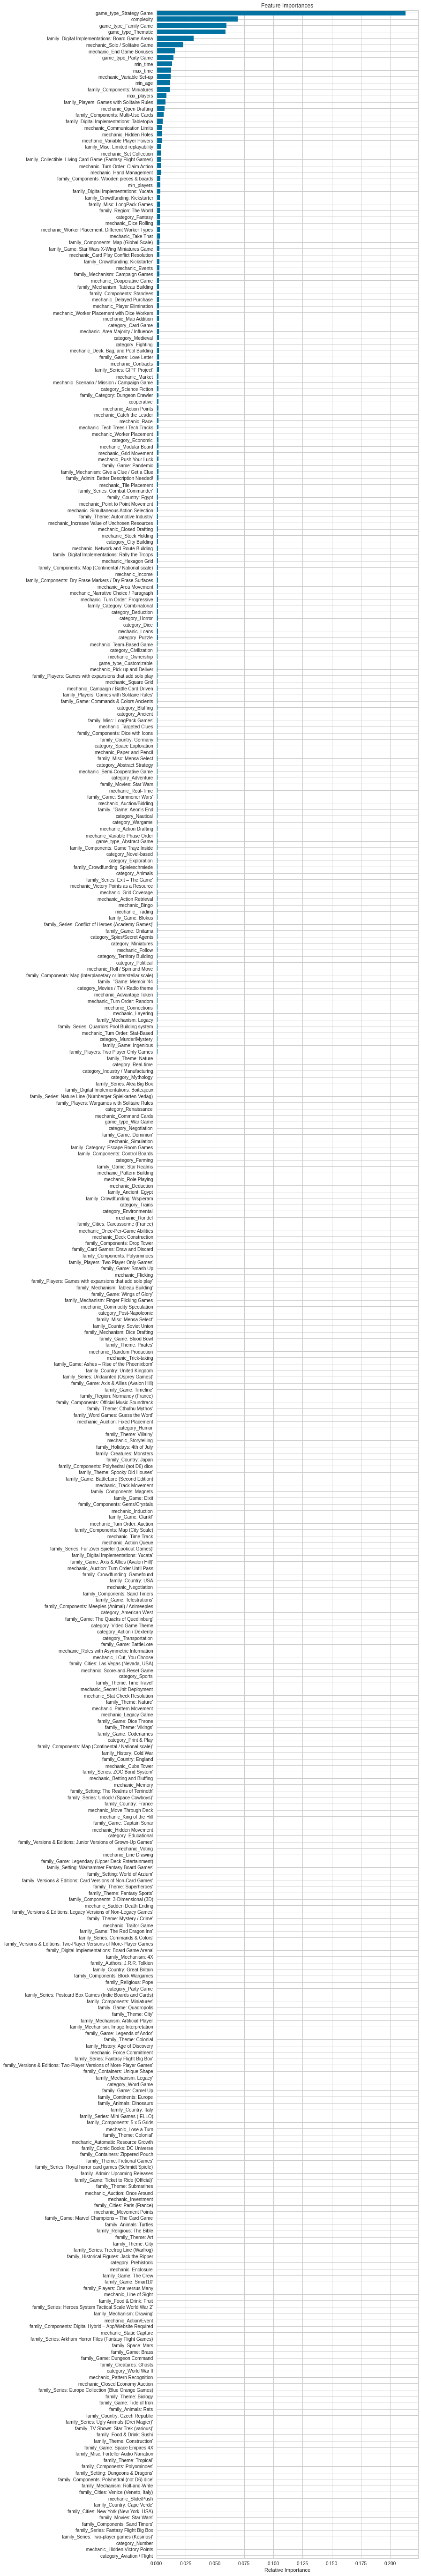

In [43]:
regr= RandomForestRegressor( random_state=RANDOM_STATE).fit(X_train, y_train)
feature_importance = regr.feature_importances_

      # Feature importance
sorted_indices = np.argsort(feature_importance)
feat_labels = X.columns

# customized number 
num_features = 400 

plt.figure(figsize=(10,100))
plt.title('Feature Importances')
plt.margins(y=0)

# only plot the customized number of features
plt.barh(range(num_features), feature_importance[sorted_indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [feat_labels[i] for i in sorted_indices[-num_features:]])
plt.xlabel('Relative Importance')

plt.show()

### Hyperparameter Tuning on Random Forest Regressor

In [100]:
#selecting top 400 features
def top_features(n):
      regr= RandomForestRegressor( random_state=RANDOM_STATE).fit(X_train, y_train)
      feature_importance = regr.feature_importances_
      sorted_indices = np.argsort(feature_importance)[::-1]
      
      feat_labels = X.columns
      key_features = []
      for f in range(n):
        key_features.append(feat_labels[sorted_indices[f]])
      
    

      new_df = game_df[key_features]
      new_df['bayes_rating']= game_df['bayes_rating']
      #dropping nans from bayes_rating
      new_df = new_df.dropna(subset=['bayes_rating'])

      #predicting bayes rating 
      X_new = new_df.drop(columns=['bayes_rating'], axis=1)

      y_target = new_df['bayes_rating']

      X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_target, random_state=RANDOM_STATE)

      X_train_new, X_test_new = simple_imputation(X_train_new, X_test_new)
      
      return X_train_new, X_test_new, y_train_new, y_test_new

In [101]:
X_train_new, X_test_new, y_train_new, y_test_new= top_features(400)

(12966, 400) (12966,)


In [44]:
# using grid search cv to find the optim,al parameters
param_grid = {  'bootstrap': [True], 'max_depth': [100,200,300], 'max_features':["auto",'sqrt'], 'n_estimators': [200, 300, 400]}

In [47]:
regr = RandomForestRegressor( random_state=RANDOM_STATE)
g_search = GridSearchCV(estimator = regr, param_grid = param_grid,   n_jobs = -1, verbose = 0, return_train_score=True)

g_search.fit(X_train_new, y_train_new)

print('Grid best parameter (max. r2 score): ', g_search.best_params_)
print('Grid best score (r2): ', g_search.best_score_)

Grid best parameter (max. accuracy):  {'bootstrap': True, 'max_depth': 200, 'max_features': 'auto', 'n_estimators': 300}
Grid best score (accuracy):  0.6047133351332765


In [51]:
# fitting the best estimator
round(g_search.score(X_test_new, y_test_new),2)

0.62

For the development model we performed tuning on the dataset containing the top 400 features identified by feature importance selection on a random forest regressor using GridSearchCV in sklearn. After iterating through this process, cross validation scores peaked at 0.62. 

Based on these results we decided to explore other feature groupings and to add other feature columns to see if that improves the score.

#**MultiLabel Classification**

## Classifying game categories/generes using game description+ game mechanics + game type + game family

In [56]:
game_df
game_df.shape

(17289, 33244)

In [53]:
# one_hot = list(game_df.columns[33:])
# one_hot.append('cooperative')
# game_df[one_hot]=game_df[one_hot].fillna(0)

#Extracting  mechanics, family & game types and using them as predictor features along with descriptions
mec_traits =[col for col in game_df[one_hot] if col.startswith('mechanic_')]
game_type_traits =[col for col in game_df[one_hot] if col.startswith('game_type_')]
family = [col for col in game_df[one_hot] if col.startswith('family_')]

In [54]:
# Selecting feature columns for the classification task
feature_columns = ['description','category']
feature_columns.extend(mec_traits)
feature_columns.extend(game_type_traits)
feature_columns.extend(family)

#Create dataframe game_category_df
game_category_df = game_df[feature_columns]


# Category is target variable
# filling Nans in category column with "no category"
game_category_df['category']= game_category_df['category'].fillna('["no category"]')



# cleaning the category column and converting it from a string to list of strings

game_category_df['cleaned_category'] = game_category_df['category'].apply(lambda x: ast.literal_eval(x))
game_category_df.dropna(inplace=True)

In [57]:
# function for text cleaning of descriptions

# Create WordNetLemmatizer object
wnl = WordNetLemmatizer()

def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", str(text) )
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",str(text)) 
    # Create a list of tokens
    list1 = nltk.word_tokenize(text)
    # Lemmatize
    lemmatized_string = ' '.join([wnl.lemmatize(words) for words in list1])
    # remove whitespaces 
    text = ' '.join(lemmatized_string.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

# removal of stopwords
stop_words = set(stopwords.words('english'))
stop_words_spa=set(stopwords.words('spanish'))

# function to remove stopwords
def remove_stopwords(text):
    if text is not None:
      no_stopword_text = [w for w in text.split() if not w in (stop_words or stop_words_spa)]
      return ' '.join(no_stopword_text)





game_category_df['cleaned_description'] = game_category_df['description'].apply(clean_text)
game_category_df['cleaned_description'] = game_category_df['cleaned_description'].apply(remove_stopwords)
#game_category_df.head()



In [58]:
# Using MultilabelBinarizer to one hot encode the target variable

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(game_category_df['cleaned_category'])

# transform target variable
y = multilabel_binarizer.transform(game_category_df['cleaned_category'])

In [ ]:
# Different game categories
multilabel_binarizer.classes_

In [59]:
# Using Cleaned Description as input feature
X= game_category_df.drop(columns=['description', 'category', 'cleaned_category'], axis=1)

# Split into train test split
xtrain, xtest, ytrain, ytest = train_test_split(X,y, random_state=RANDOM_STATE)

In [60]:
# create TF-IDF features
vectorizer=TfidfVectorizer(max_features = 10000, ngram_range = (1,2),min_df=0.01)
X_train_des = vectorizer.fit_transform(xtrain['cleaned_description']).toarray()

X_test_des = vectorizer.transform(xtest['cleaned_description']).toarray()

xtrain = xtrain.drop(columns='cleaned_description')
xtest = xtest.drop(columns='cleaned_description')

In [61]:
# Combining the original one hot encoded columns(mech, family, game_type) along with the tfidf vector columns in xtrain, xtest
for i, col in enumerate(vectorizer.get_feature_names()):
    xtrain[col] = X_train_des[:, i]
    xtest[col] = X_test_des[:, i]

xtrain.shape, xtest.shape

((12966, 6946), (4322, 6946))

### Train and Evaluate Classifiers

In [63]:
# evaluation metrics -  hamming loss, precision, recall & F1 score
ModelsPerformance = {}

def metricsReport(modelName, test_labels, predictions):
    

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName + " Model Metrics-----")
    print("Hamming Loss: {:.4f}\nPrecision:\n  - Micro: {:.4f}\nRecall:\n  - Micro: {:.4f}\nF1-measure:\n  - Micro: {:.4f}"\
          .format(hamLoss, micro_precision, micro_recall, micro_f1))
    ModelsPerformance[modelName] = micro_f1

In [64]:
# Logistic Regression

log_reg = OneVsRestClassifier(LogisticRegression(random_state= RANDOM_STATE))
# fit model on train data
log_reg.fit(xtrain, ytrain)
# make predictions for test set
logPreds = log_reg.predict(xtest)
metricsReport("Logistic Regression", ytest, logPreds)

------Logistic Regression Model Metrics-----
Hamming Loss: 0.0206
Precision:
  - Micro: 0.8177
Recall:
  - Micro: 0.4509
F1-measure:
  - Micro: 0.5813


In [65]:
# GradientBoostingClassifier

boostClassifier = OneVsRestClassifier(GradientBoostingClassifier(random_state= RANDOM_STATE),n_jobs=-1)
boostClassifier.fit(xtrain, ytrain)
boostPreds = boostClassifier.predict(xtest)
metricsReport("Gradient Boosting", ytest, boostPreds)

------Gradient Boosting Model Metrics-----
Hamming Loss: 0.0230
Precision:
  - Micro: 0.7196
Recall:
  - Micro: 0.4466
F1-measure:
  - Micro: 0.5512


In [66]:
# LinearSVC

svmClassifier = OneVsRestClassifier(LinearSVC(random_state= RANDOM_STATE), n_jobs=-1)
svmClassifier.fit(xtrain, ytrain)
svmPreds= svmClassifier.predict(xtest)
metricsReport("SVC ", ytest, svmPreds)

------SVC  Model Metrics-----
Hamming Loss: 0.0216
Precision:
  - Micro: 0.7147
Recall:
  - Micro: 0.5300
F1-measure:
  - Micro: 0.6087


In [67]:
# nbClassifier

nbClassifier = OneVsRestClassifier(MultinomialNB())
nbClassifier.fit(xtrain, ytrain)
nbPreds = nbClassifier.predict(xtest)
metricsReport("Multinomial NB",  ytest, nbPreds)

------Multinomial NB Model Metrics-----
Hamming Loss: 0.0253
Precision:
  - Micro: 0.6592
Recall:
  - Micro: 0.4177
F1-measure:
  - Micro: 0.5114


In [68]:
print("  Model Name " + " "*10 + "| Micro-F1 Score")
print("-------------------------------------------")
for key, value in ModelsPerformance.items():
    print("  " + key, " "*(20-len(key)) + "|", round(value,3))
    print("-------------------------------------------")

  Model Name           | Micro-F1 Score
-------------------------------------------
  Logistic Regression  | 0.581
-------------------------------------------
  Gradient Boosting    | 0.551
-------------------------------------------
  SVC                  | 0.609
-------------------------------------------
  Multinomial NB       | 0.511
-------------------------------------------


Manually check the assigned categories by the LinearSVC model

In [ ]:
# Actual categories, Example-
print(game_category_df.cleaned_category.iloc[14])


# using inverse_transform( ) function along with the MultiLabelBinarizer( ) object to convert the predicted arrays into game categories
multilabel_binarizer.inverse_transform(svmPreds)[14]


### Hyperparameter Tuning on Linear SVC - using GridSearch

In [69]:
param_grid = {'estimator__C' : [0.01,0.1, 1,10],'estimator__penalty':['l1','l2'], 'estimator__loss':['hinge', 'squared_hinge']}

In [70]:
base_estimator = OneVsRestClassifier(LinearSVC(random_state=RANDOM_STATE))
gsearch_cv = GridSearchCV(base_estimator, param_grid, scoring='f1_micro', n_jobs=-1, verbose=0, cv=3 )


# fitting the model for grid search 
gsearch_cv.fit(xtrain, ytrain)
 
# print best parameter after tuning 
print(gsearch_cv.best_params_) 
grid_predictions = gsearch_cv.predict(xtest)

{'estimator__C': 1, 'estimator__loss': 'hinge', 'estimator__penalty': 'l2'}


In [71]:
# Fitting the best estimator
print("F1 score - {}".format(round(gsearch_cv.best_score_, 3)))
print("Prescision score - {}".format(round(precision_score(ytest, grid_predictions, average='micro'),3)))
print("Recall score - {}".format(round(recall_score(ytest, grid_predictions, average='micro'),3)))
print("Hamming Loss - {}".format(round(hamming_loss(ytest, grid_predictions),3)))


F1 score - 0.601
Prescision score - 0.758
Recall score - 0.519
Hamming Loss - 0.02


### Cross Validation- Using LinearSVC Classifier

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The k fold cross validation procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. Here we choose a 10 fold cross validation

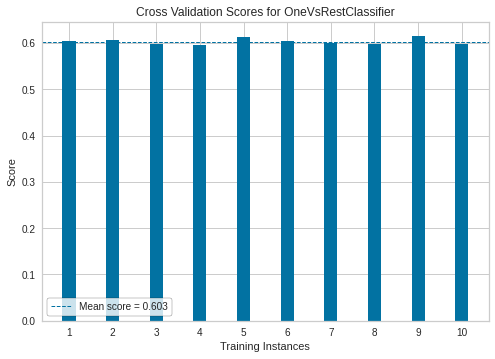

In [72]:
# Create a cross-validation strategy
cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Instantiate the classification model and visualizer
base_estimator = OneVsRestClassifier(LinearSVC(random_state=RANDOM_STATE, C=1, penalty='l2'))
visualizer = CVScores(base_estimator, cv=cv, scoring='f1_micro')

visualizer.fit(xtrain, ytrain)       # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

### Dummy Classifier

DummyClassifier is a classifier that makes predictions using simple rules, which can be useful as a baseline for comparison against actual classifiers, especially with imbalanced classes.

In [75]:
clf_dummy = DummyClassifier(strategy='stratified',random_state=RANDOM_STATE) 
#establishing random_state for reproducibility
clf_dummy.fit(xtrain, ytrain)
y_pred_dummy = clf_dummy.predict(xtest)
round(f1_score(ytest, y_pred_dummy, average="micro"),3) 

0.094

### Precision Recall curve- Using LinearSVC Classifier

A PR curve is simply a graph with Precision values on the y-axis and Recall values on the x-axis.

In [76]:
# Linear SVC
svmClassifier = OneVsRestClassifier(LinearSVC(random_state= RANDOM_STATE, C=1), n_jobs=-1)
svmClassifier.fit(xtrain, ytrain)
y_score = svmClassifier.decision_function(xtest)

In [77]:
n_classes= y.shape[1]
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(ytest[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(ytest[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    ytest.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(ytest, y_score, average="micro")

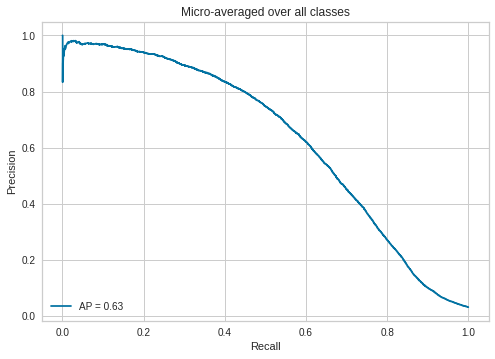

In [78]:
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

 Average Precision is a single number used to summarise a Precision-Recall curve. Here we can see the value is 0.63. It also characterizes the performance of a classifier, higher the better.

### Sensitivity Analysis - Using Linear SVC

A line chart depicting divergence of training & test F1 scores at different levels of regularization (C)

In [102]:
acc = []
acc_tr = []
i = 0
df = pd.DataFrame(columns = ['c','train_acc','test_acc'])
for c in [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]:
    svm = OneVsRestClassifier(LinearSVC( C=c))
    svm.fit(xtrain, ytrain)
   
    p_tr = svm.predict(xtrain)
    a_tr = round(f1_score(ytrain, p_tr, average='micro'),3)
    
    pred = svm.predict(xtest)
    a = round(f1_score(ytest, pred, average='micro'),3)
    

    acc_tr.append(a_tr)
    acc.append(a)
    df.loc[i] = [c,a_tr,a]
    i=i+1


df

,c,train_acc,test_acc
0,0.0001,0.111,0.112
1,0.0010,0.250,0.244
2,0.0100,0.464,0.432
3,0.1000,0.731,0.589
4,1.0000,0.942,0.609
5,10.0000,0.993,0.553
6,100.0000,0.996,0.530
7,1000.0000,0.996,0.527
8,10000.0000,0.994,0.528


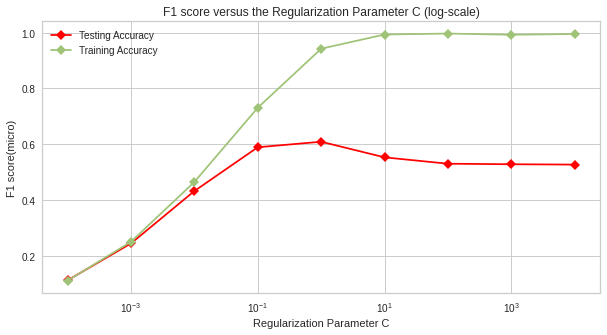

In [80]:
c = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

plt.subplots(figsize=(10, 5))
plt.semilogx(c, acc,'-gD' ,color='red' , label="Testing Accuracy")
plt.semilogx(c, acc_tr,'-gD' , label="Training Accuracy")
plt.grid(True)
plt.xlabel("Regularization Parameter C")
plt.ylabel("F1 score(micro)")
plt.legend()
plt.title('F1 score versus the Regularization Parameter C (log-scale)')
plt.show()

Increases in C link to increases in F1 scores until C reaches a value of one. Larger values represent less regularization which causes the model to fit the training set with as few errors as possible. C=1 has the best test accuracy. From a C of ten and up, the model begins overfitting to the training data

After performing 10-fold cross validation and hyperparameter tuning, the model achieves a maximum micro-averaged F1 score of 0.60, recall value of 0.519, precision value of 0.758 and hamming loss of 0.021 using LinearSVC. We can manually observe categories assigned to each game using MultiBinarizer’s inverse function. These predictions were made based on a threshold value of 0.5, which means that the probabilities greater than or equal to 0.5 were converted to 1’s and the rest to 0’s. 